In [240]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix, csr_matrix
from mpl_toolkits.mplot3d import Axes3D


colors = {
    "midnight": "#21252d",
    "mathblue": "#1b91d6",
    "sky": "#8ecae6",
    "slatecard": "#1a1e2a",
    "lightblue": "#bfdbfe",
    "hoverblue": "#60a5fa",
    "slategray": "#1a1e2a",
    "softgray": "#9ca3af"
}

# Poisson and Laplace Equation

## Steps to solve:
```python
class PoissonSolver2D:
    def __init__(self, f, domain, Nx, Ny, bc_dict):
        self.f = f
        self.domain = domain
        self.Nx, self.Ny = Nx, Ny
        self.bc = bc_dict

    def setup_grid(self):
        # setup x, y, h
        pass

    def apply_boundary_conditions(self):
        # handle Dirichlet, Neumann, etc.
        pass

    def assemble_matrix(self):
        # create sparse matrix A and RHS b
        pass

    def solve(self):
        # solve Au = b
```

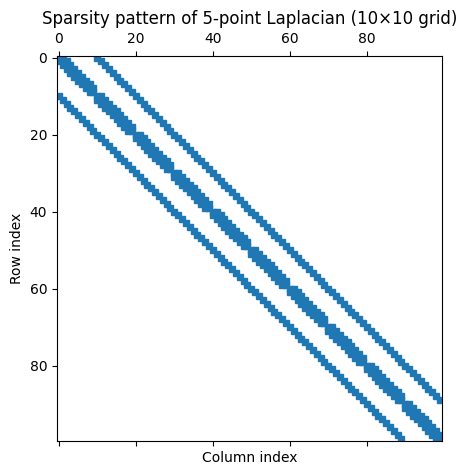

In [241]:
def build_laplacian(Nx, Ny):
    # returns CSR sparse matrix for the 5-point stencil
    data, rows, cols = [], [], []
    for j in range(Ny):
        for i in range(Nx):
            k = i + j*Nx          # flattened index
            rows += [k]; cols += [k]; data += [4.0]     # centre
            if i > 0:         rows += [k]; cols += [k-1];   data += [-1.0]
            if i < Nx-1:      rows += [k]; cols += [k+1];   data += [-1.0]
            if j > 0:         rows += [k]; cols += [k-Nx];  data += [-1.0]
            if j < Ny-1:      rows += [k]; cols += [k+Nx];  data += [-1.0]
    return sparse.csr_matrix((data, (rows, cols)), shape=(Nx*Ny, Nx*Ny))

Nx, Ny = 10, 10          # interior-grid dimensions – change as you like
A = build_laplacian(Nx, Ny)

plt.figure(figsize=(5,5))
plt.spy(A, markersize=5)
plt.title(f"Sparsity pattern of 5-point Laplacian ({Ny}×{Nx} grid)")
plt.xlabel("Column index"); plt.ylabel("Row index")
plt.show()


## Dirichlet (fixed value)


## Mixed / Robin Boundary

- combines Dirichlet and Neumann behaviour

$$
\alpha u +\beta \frac{\partial u}{\partial n} = \gamma
$$
- $\alpha = 1, \beta = 0 \implies $ pure Dirichlet
- $\alpha = 0, \beta = 1 \implies $ pure Neumann
- Typical heat-transfer form (Newton cooling): 
$$
\beta = k, \alpha = h_c, \gamma = h_c T_\infty
$$

---
1. First-order ghost-cell formula

On our uniform grid the outward normal derivative is approximated by:
$$
\frac{\partial u}{\partial n} \approx \frac{u_G - u_P}{h}
$$
so at a wall node $P$, the robin condition becomes:
$$
\alpha u_P +\beta \frac{u_G - u_P}{h} = \gamma
$$
solving for ghost value $u_G$ :
$$
u_G = u_P +\frac{h}{\beta}\left(\gamma -\alpha u_P\right)
$$
Set this each sweep so the ghost layer tracks the evolving interior.

---


## Neumann (flux) boundaries
the normal derivative 
$$
\frac{\partial u}{\partial n} \bigg\vert_{\text{wall}} = q(x,y),
$$
fixes the (heat)flux instead of temperature. On a uniform finite-difference grid the simplest (first-order) ghost-cell update is:
$$
u_G = u_P +qh
$$
where
- $u_P$ is the interior node adjacent to the wall
- $u_G$ is the ghost value just outside the wall,
- $h$ is grid spacing
- $q$ is derivative in the outward normal direction
    - positive $q$ means flux out of domain
Need to perform this update every sweep as $u_P$ keeps changing.


## Step 1: Problem Statement & Grid Discretization

Want to solve 2-d Poisson equation:
$$
-\nabla^2 u(x,y) = f(x,y), \quad (x,y) \in \Omega = [a,b] \times [c,d]
$$
with Dirchlet boundary conditions: 
$$
u(x,y) = g(x,y) \text{ on } \partial \Omega 
$$

## Discretize the domain $\Omega$ into a **uniform grid**

### 🧮 Mathematical Setup

We discretize the domain $\Omega$ into a **uniform grid**:

* $x_i = a + i h_x,\quad i = 0, 1, \dots, N_x$
* $y_j = c + j h_y,\quad j = 0, 1, \dots, N_y$
* Grid spacings: $h_x = \frac{b-a}{N_x},\quad h_y = \frac{d-c}{N_y}$

At each grid point $(x_i, y_j)$, we will approximate $u(x_i, y_j)$ by $u_{i,j}$

---

### 🧱 Discretization of $-\nabla^2 u$

Using second-order **central differences**, the Laplacian becomes:

$$
- \nabla^2 u(x_i, y_j) \approx -\left( \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2} \right)
$$

We’ll use this stencil to build a matrix equation.

---


In [242]:
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny):
        self.a, self.b = a, b  # x-domain
        self.c, self.d = c, d  # y-domain
        self.Nx, self.Ny = Nx, Ny  # number of intervals

        # Step sizes
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny

        # Grid points (including boundaries)
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)

        # Meshgrid for convenience
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        print(f"Grid setup complete: hx = {self.hx}, hy = {self.hy}")


In [243]:
solver = PoissonSolver2D(a=0, b=1, c=0, d=1, Nx=4, Ny=4)
print(solver.X)


Grid setup complete: hx = 0.25, hy = 0.25
[[0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.25]
 [0.5  0.5  0.5  0.5  0.5 ]
 [0.75 0.75 0.75 0.75 0.75]
 [1.   1.   1.   1.   1.  ]]


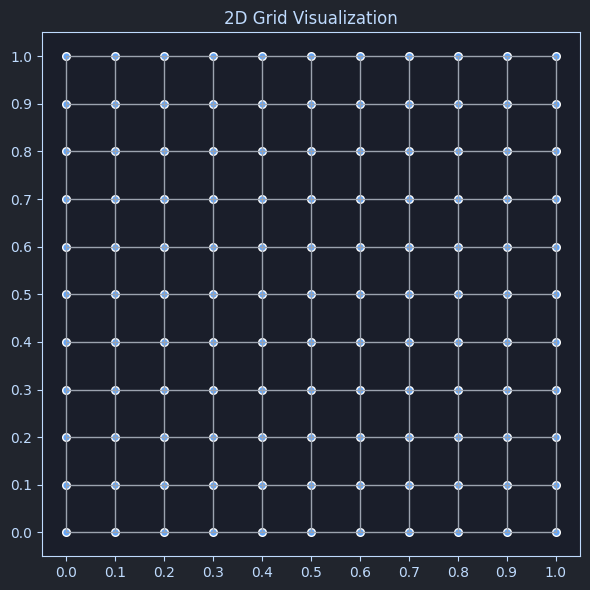

In [244]:
# Define the grid parameters
a, b, c, d = 0, 1, 0, 1
Nx, Ny = 10, 10
hx = (b - a) / Nx
hy = (d - c) / Ny

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')


# Plot the grid
fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor(colors["midnight"])
ax.set_facecolor(colors["slatecard"])

# Plot horizontal lines
for j in range(Ny + 1):
    ax.plot([a, b], [y[j], y[j]], color=colors["softgray"], linewidth=1)

# Plot vertical lines
for i in range(Nx + 1):
    ax.plot([x[i], x[i]], [c, d], color=colors["softgray"], linewidth=1)

# Plot grid points
ax.scatter(X, Y, color=colors["hoverblue"], s=30, edgecolor='white')

# Aesthetic settings
ax.set_xlim(a - 0.05, b + 0.05)
ax.set_ylim(c - 0.05, d + 0.05)
ax.set_xticks(x)
ax.set_yticks(y)
ax.tick_params(colors=colors["lightblue"])
for spine in ax.spines.values():
    spine.set_edgecolor(colors["lightblue"])
ax.set_title("2D Grid Visualization", color=colors["lightblue"])

plt.grid(False)
plt.tight_layout()
plt.show()

##  Step 2: Setting Up the Right-Hand Side and Dirichlet BCs

We want to solve:

$$
- \nabla^2 u(x, y) = f(x, y), \quad \text{with } u(x, y) = g(x, y) \text{ on } \partial \Omega
$$

### 🎯 Objectives

1. Discretize $f(x, y)$ on the grid interior (i.e., not on boundaries).
2. Create an array `u` initialized with zeros.
3. Apply **Dirichlet** boundary conditions: explicitly set values of `u` on the domain boundary.

---

### 🧮 Mathematical View

Let $f_{i,j} = f(x_i, y_j)$ evaluated on the grid.
Dirichlet boundary conditions mean:

* For all points on the edge (i=0, i=Nx, j=0, j=Ny), set $u_{i,j} = g(x_i, y_j)$

This becomes:

* **Top** boundary → $j = Ny$
* **Bottom** boundary → $j = 0$
* **Left** boundary → $i = 0$
* **Right** boundary → $i = Nx$

We'll store this in a full 2D array `u[i, j]`.

---

### 🧑‍💻 Code: Setup `f(x, y)` and Apply Dirichlet BC


In [245]:
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny, f_func, g_func):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny

        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.g_func = g_func

        # Evaluate f on the grid
        self.f = f_func(self.X, self.Y)

        # Solution array
        self.u = np.zeros_like(self.f)

        # Apply Dirichlet boundary conditions
        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        g = self.g_func

        # Left and Right boundaries
        self.u[0, :] = g(self.x[0], self.y)
        self.u[-1, :] = g(self.x[-1], self.y)

        # Bottom and Top boundaries
        self.u[:, 0] = g(self.x, self.y[0])
        self.u[:, -1] = g(self.x, self.y[-1])

---

### 🔍 Notes

* `f_func(x, y)` and `g_func(x, y)` are user-defined functions.
* `self.f` stores the discretized version of $f(x,y)$
* `self.u` stores the solution, with boundaries set according to $g(x,y)$

---

### ✅ Example Usage

Let’s use:

* $f(x,y) = 2\pi^2 \sin(\pi x)\sin(\pi y)$
* $g(x,y) = 0$ on boundary (homogeneous Dirichlet)

In [246]:
f = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g = lambda x, y: 0 * x  # all boundaries = 0

solver = PoissonSolver2D(0, 1, 0, 1, 10, 10, f_func=f, g_func=g)

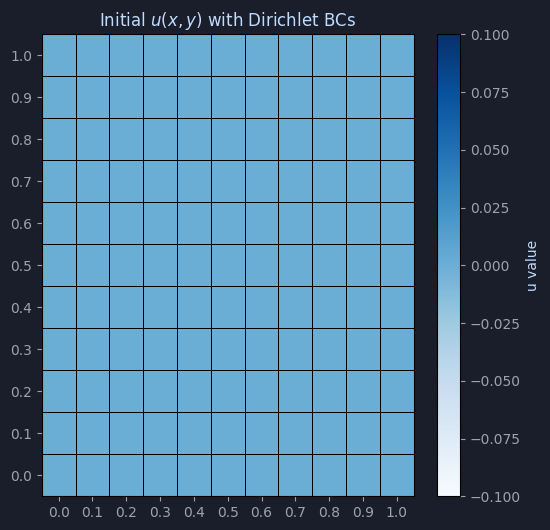

In [247]:

# Define domain and functions
a, b, c, d = 0, 1, 0, 1
Nx, Ny = 10, 10
hx = (b - a) / Nx
hy = (d - c) / Ny

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Function f(x, y) = 2π² sin(πx) sin(πy)
f_func = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g_func = lambda x, y: 0 * x  # homogeneous Dirichlet

# Evaluate functions
f_vals = f_func(X, Y)
u_vals = np.zeros_like(f_vals)

# Apply Dirichlet BCs
u_vals[0, :] = g_func(x[0], y)
u_vals[-1, :] = g_func(x[-1], y)
u_vals[:, 0] = g_func(x, y[0])
u_vals[:, -1] = g_func(x, y[-1])


# Plot u values including boundary
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor(colors["midnight"])
fig.patch.set_facecolor(colors["slategray"])

c = ax.pcolormesh(X, Y, u_vals.T, shading='auto', cmap='Blues', edgecolors='k', linewidth=0.5)
ax.set_title("Initial $u(x, y)$ with Dirichlet BCs", color=colors["lightblue"])
ax.set_xticks(np.round(x, 2))
ax.set_yticks(np.round(y, 2))
ax.tick_params(colors=colors["softgray"])
cb = fig.colorbar(c, ax=ax)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])  # Tick marks and labels

plt.show()


---

## 🔷 Step 3: Assembling the Sparse Matrix and Solving $A\mathbf{u} = \mathbf{f}$

We’ve set up the grid and applied Dirichlet boundary conditions. Now we will:

1. Discretize the Poisson equation at interior points.
2. Set up the sparse matrix $A$ corresponding to the 5-point stencil.
3. Flatten the system into vector form: $A \mathbf{u} = \mathbf{f}$
4. Solve it using a linear solver.

---

### 🎯 Mathematical Discretization

Recall:

$$
- \nabla^2 u(x_i, y_j) \approx -\left( \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2} \right)
$$

Define:

* $N = (N_x - 1)(N_y - 1)$: number of **interior** unknowns
* For interior points only: $1 \le i \le N_x - 1$, $1 \le j \le N_y - 1$

We flatten the 2D grid to 1D using **row-major order**:

$$
k = (i-1) \cdot (N_y - 1) + (j-1)
$$

---

### 🔧 Finite Difference Stencil in Matrix Form

Each interior point $u_{i,j}$ becomes one equation:

$$
A_{kk} = -2\left(\frac{1}{h_x^2} + \frac{1}{h_y^2}\right),\quad
A_{k,k\pm1} = \frac{1}{h_y^2},\quad
A_{k,k\pm(N_y-1)} = \frac{1}{h_x^2}
$$

This yields a **sparse matrix $A$**.

---

### 🧑‍💻 Code to Build A and Solve System


In [248]:
class PoissonSolver2D: #only square grid
    def __init__(self, a, b, c, d, Nx, Ny, f_func, g_func):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.g_func = g_func
        self.f = f_func(self.X, self.Y)
        self.u = np.zeros_like(self.f)

        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        g = self.g_func
        self.u[0, :] = g(self.x[0], self.y)
        self.u[-1, :] = g(self.x[-1], self.y)
        self.u[:, 0] = g(self.x, self.y[0])
        self.u[:, -1] = g(self.x, self.y[-1])

    def solve(self):
        Nx, Ny = self.Nx, self.Ny
        hx2 = self.hx ** 2
        hy2 = self.hy ** 2
        N = (Nx - 1) * (Ny - 1)

        A = lil_matrix((N, N))
        F = np.zeros(N)

        def idx(i, j):  # Convert (i,j) to 1D index
            return (i - 1) * (Ny - 1) + (j - 1)

        for i in range(1, Nx):
            for j in range(1, Ny):
                k = idx(i, j)
                A[k, k] = -2.0 * (1 / hx2 + 1 / hy2)

                # Neighbors
                if i > 1:
                    A[k, idx(i - 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i - 1, j] / hx2  # Left boundary

                if i < Nx - 1:
                    A[k, idx(i + 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i + 1, j] / hx2  # Right boundary

                if j > 1:
                    A[k, idx(i, j - 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j - 1] / hy2  # Bottom boundary

                if j < Ny - 1:
                    A[k, idx(i, j + 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j + 1] / hy2  # Top boundary

                F[k] += self.f[i, j]

        # Convert to CSR and solve
        A_csr = A.tocsr()
        u_inner = spsolve(A_csr, F)

        # Fill in the interior of u
        for i in range(1, Nx):
            for j in range(1, Ny):
                self.u[i, j] = u_inner[idx(i, j)]

        return self.u

In [249]:
f = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g = lambda x, y: 0 * x

solver = PoissonSolver2D(0, 1, 0, 1, 20, 20, f_func=f, g_func=g)
u_numeric = solver.solve()

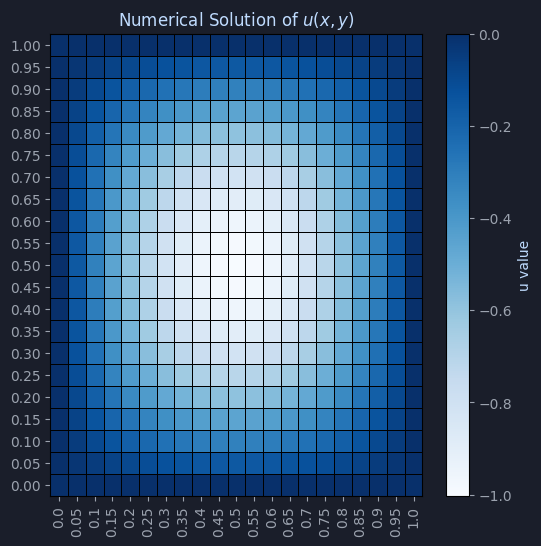

In [250]:
# Define domain and function
a, b, c, d = 0, 1, 0, 1
Nx, Ny = 20, 20
hx = (b - a) / Nx
hy = (d - c) / Ny

x = np.linspace(a, b, Nx + 1)
y = np.linspace(c, d, Ny + 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Functions
f_func = lambda x, y: 2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
g_func = lambda x, y: 0 * x

# Solve
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func, g_func)
u_numeric = solver.solve()

# Plot solution
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor(colors["midnight"])
fig.patch.set_facecolor(colors["slategray"])

c = ax.pcolormesh(solver.X, solver.Y, u_numeric.T, shading='auto', cmap='Blues', edgecolors='k', linewidth=0.5)
ax.set_title("Numerical Solution of $u(x, y)$", color=colors["lightblue"])
ax.set_xticks(np.round(x, 2))
ax.set_xticklabels(np.round(x, 2), rotation=90)  # <-- rotate x-tick labels
ax.set_yticks(np.round(y, 2))
ax.tick_params(colors=colors["softgray"])
cb = fig.colorbar(c, ax=ax)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])

plt.show()


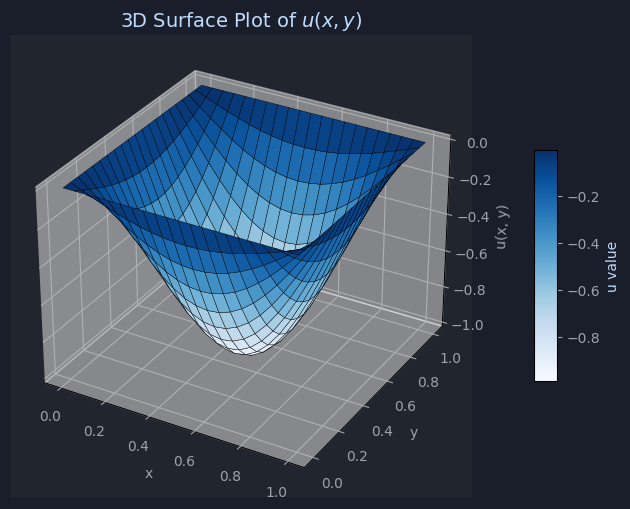

In [251]:

# 3D Surface Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot surface
surf = ax.plot_surface(solver.X, solver.Y, u_numeric, cmap='Blues', edgecolor='k', linewidth=0.3, antialiased=True)

# Axis labels
ax.set_title("3D Surface Plot of $u(x, y)$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("u(x, y)", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Color bar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cb.set_label("u value", color=colors["lightblue"])
cb.ax.tick_params(colors=colors["softgray"])

plt.show()

# Examples
1. Approximate the solution to the elliptic partial differential equation
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 4, \quad 0 < x < 1, \quad 0 < y < 2; $$
$$ u(x, 0) = x^2, \quad u(x, 2) = (x-2)^2, \quad 0 \leq x \leq 1; $$
$$ u(0, y) = y^2, \quad u(1, y) = (y-1)^2, \quad 0 \leq y \leq 2. $$
Use $h=k=\frac{1}{2}$ and compare the results to the actual solution $u(x, y) = (x-y)^2$.

2. Approximate the solution to the elliptic partial differential equation
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, \quad 1 < x < 2, \quad 0 < y < 1; $$
$$ u(x, 0) = 2 \ln x, \quad u(x, 1) = \ln(x^2 + 1), \quad 1 \leq x \leq 2; $$
$$ u(1, y) = \ln(y^2 + 1), \quad u(2, y) = \ln(y^2 + 4), \quad 0 \leq y \leq 1. $$
Use $h=k=\frac{1}{3}$ and compare the results to the actual solution $u(x, y) = \ln(x^2 + y^2)$.

## 3. Approximate the solutions to the following elliptic partial differential equations:

### a.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, \quad 0 < x < 1,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(x, 0) = 0$, $u(x, 1) = x$, $0 \leq x \leq 1$
- $u(0, y) = 0$, $u(1, y) = y$, $0 \leq y \leq 1$

Use $h = k = 0.2$ and compare the results to the actual solution:

$$
u(x, y) = xy
$$

---

### b.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -(\cos(x + y) + \cos(x - y)), \quad 0 < x < \pi,\quad 0 < y < \frac{\pi}{2};
$$

Boundary conditions:

- $u(0, y) = \cos y$, $u(\pi, y) = -\cos y$, $0 \leq y \leq \frac{\pi}{2}$
- $u(x, 0) = \cos x$, $u\left(x, \frac{\pi}{2}\right) = 0$, $0 \leq x \leq \pi$

Use $h = \pi/5$ and $k = \pi/10$ and compare the results to the actual solution:

$$
u(x, y) = \cos x \cos y
$$

---

### c.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = (x^2 + y^2) e^{xy},\quad 0 < x < 2,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(0, y) = 1$, $u(2, y) = e^{2y}$, $0 \leq y \leq 1$
- $u(x, 0) = 1$, $u(x, 1) = e^x$, $0 \leq x \leq 2$

Use $h = 0.2$ and $k = 0.1$ and compare the results to the actual solution:

$$
u(x, y) = e^{xy}
$$

---

### d.

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = \frac{x}{y} + \frac{y}{x},\quad 1 < x < 2,\quad 1 < y < 2;
$$

Boundary conditions:

- $u(x, 1) = x \ln x$, $u(x, 2) = x \ln(4x^2)$, $1 \leq x \leq 2$
- $u(1, y) = y \ln y$, $u(2, y) = 2y \ln(2y)$, $1 \leq y \leq 2$

Use $h = k = 0.1$ and compare the results to the actual solution:

$$
u(x, y) = xy \ln(xy)
$$

---

## 4.

Repeat Exercise 3(a) using extrapolation with $h_0 = 0.2$, $h_1 = h_0 / 2$, and $h_2 = h_0 / 4$.

## Applied Exercises

### 5.

A coaxial cable is made of a 0.1-in.-square inner conductor and a 0.5-in.-square outer conductor.  
The potential at a point in the cross section of the cable is described by Laplace’s equation.  
Suppose the inner conductor is kept at 0 volts and the outer conductor is kept at 110 volts.  
Find the potential between the two conductors by placing a grid with horizontal mesh spacing  
$h = 0.1$ in. and vertical mesh spacing $k = 0.1$ in. on the region

$$
D = \{(x, y) \mid 0 \leq x, y \leq 0.5 \}.
$$

Approximate the solution to Laplace’s equation at each grid point and use the two sets of boundary conditions to derive a linear system to be solved by the Gauss-Seidel method.

---

### 6.

A 6-cm by 5-cm rectangular silver plate has heat being uniformly generated at each point at the rate  
$q = 1.5$ cal/cm³·sec. Let $x$ represent the distance along the edge of the plate of length 6 cm and $y$ be the distance along the edge of the plate of length 5 cm.  
Suppose the temperature $u$ along the edges is kept at the following temperatures:

- $u(x, 0) = x(6 - x)$, $u(x, 5) = 0$, $0 \leq x \leq 6$
- $u(0, y) = y(5 - y)$, $u(6, y) = 0$, $0 \leq y \leq 5$

The Poisson equation governing the steady-state temperature $u = u(x, y)$ is:

$$
\frac{\partial^2 u}{\partial x^2}(x, y) + \frac{\partial^2 u}{\partial y^2}(x, y) = -\frac{q}{K}, \quad 0 < x < 6,\quad 0 < y < 5,
$$

where $K$, the thermal conductivity, is $1.04$ cal/cm·deg·sec.  
Approximate the temperature $u(x, y)$ using Algorithm 12.1 with $h = 0.4$ and $k = \frac{1}{3}$.




## Problem 1

In [252]:
class PoissonSolver2D:
    def __init__(self, a, b, c, d, Nx, Ny, f_func,
                 g_left, g_right, g_bottom, g_top):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.Nx, self.Ny = Nx, Ny
        self.hx = (b - a) / Nx
        self.hy = (d - c) / Ny
        self.x = np.linspace(a, b, Nx + 1)
        self.y = np.linspace(c, d, Ny + 1)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.f_func = f_func
        self.f = f_func(self.X, self.Y)

        self.g_left = g_left
        self.g_right = g_right
        self.g_bottom = g_bottom
        self.g_top = g_top

        self.u = np.zeros_like(self.f)

        self.apply_dirichlet_bc()

    def apply_dirichlet_bc(self):
        # Apply to edges
        self.u[0, :] = self.g_left(self.y)
        self.u[-1, :] = self.g_right(self.y)
        self.u[:, 0] = self.g_bottom(self.x)
        self.u[:, -1] = self.g_top(self.x)

    def solve(self):
        from scipy.sparse import lil_matrix
        from scipy.sparse.linalg import spsolve

        Nx, Ny = self.Nx, self.Ny
        hx2 = self.hx ** 2
        hy2 = self.hy ** 2
        N = (Nx - 1) * (Ny - 1)

        A = lil_matrix((N, N))
        F = np.zeros(N)

        def idx(i, j):
            return (i - 1) * (Ny - 1) + (j - 1)

        for i in range(1, Nx):
            for j in range(1, Ny):
                k = idx(i, j)
                A[k, k] = -2.0 * (1 / hx2 + 1 / hy2)

                if i > 1:
                    A[k, idx(i - 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i - 1, j] / hx2

                if i < Nx - 1:
                    A[k, idx(i + 1, j)] = 1 / hx2
                else:
                    F[k] -= self.u[i + 1, j] / hx2

                if j > 1:
                    A[k, idx(i, j - 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j - 1] / hy2

                if j < Ny - 1:
                    A[k, idx(i, j + 1)] = 1 / hy2
                else:
                    F[k] -= self.u[i, j + 1] / hy2

                F[k] += self.f[i, j]

        u_inner = spsolve(A.tocsr(), F)

        for i in range(1, Nx):
            for j in range(1, Ny):
                self.u[i, j] = u_inner[idx(i, j)]

        return self.u


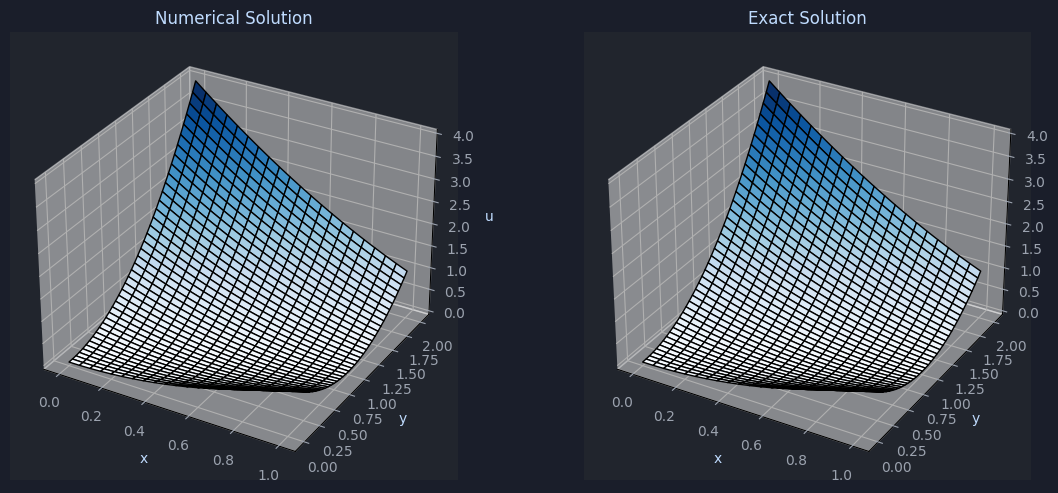

In [253]:
# Define problem-specific functions for test case
a, b = 0, 1
c, d = 0, 2
Nx, Ny = 20, 40 # h = k = 0.5 -> (Nx+1)x(Ny+1) = 3 x 5 grid

# RHS of Poisson equation
f_func = lambda x, y: 4 * np.ones_like(x)

# Dirichlet boundary conditions
g_bottom = lambda x: x**2
g_top = lambda x: (x - 2)**2
g_left = lambda y: y**2
g_right = lambda y: (y - 1)**2

# Exact solution
u_exact = lambda x, y: (x - y)**2

# Create and solve
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()

# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()

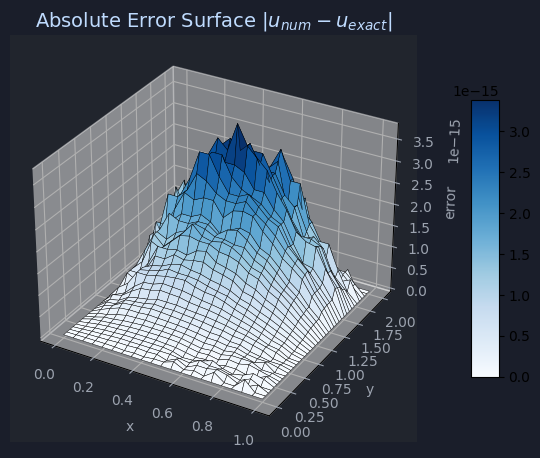

In [254]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)

plt.show()


## Problem 2

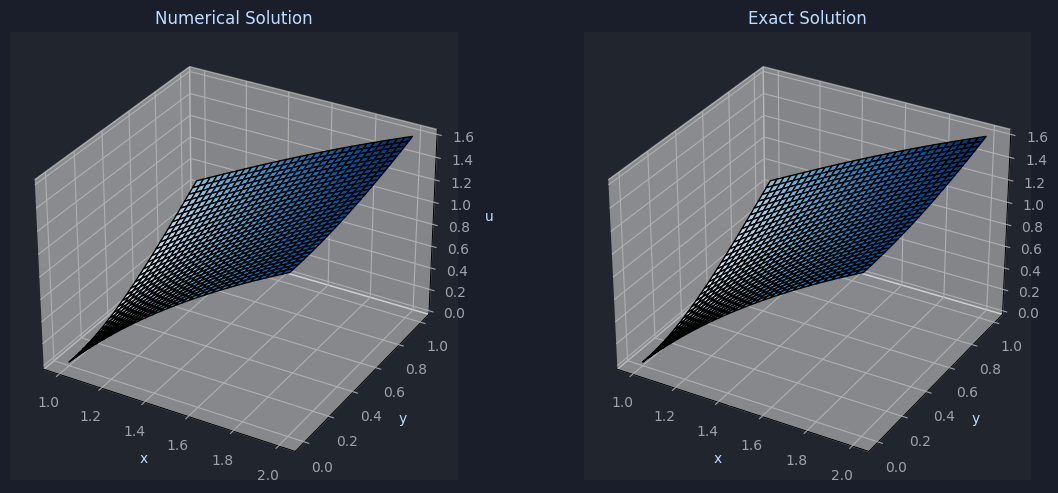

In [255]:
# Define domain and resolution
a, b = 1, 2
c, d = 0, 1
Nx, Ny = 30, 30  # h = k = 1/3 -> (Nx+1)x(Ny+1) = 4 x 4 grid

# Define f(x, y) = 0 (Laplace's equation)
f_func = lambda x, y: np.zeros_like(x)

# Define boundary conditions
g_bottom = lambda x: 2 * np.log(x)             # u(x, 0)
g_top = lambda x: np.log(x**2 + 1)             # u(x, 1)
g_left = lambda y: np.log(y**2 + 1)            # u(1, y)
g_right = lambda y: np.log(y**2 + 4)           # u(2, y)

# Define exact solution
u_exact = lambda x, y: np.log(x**2 + y**2)

# Solve using the updated class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()

# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()


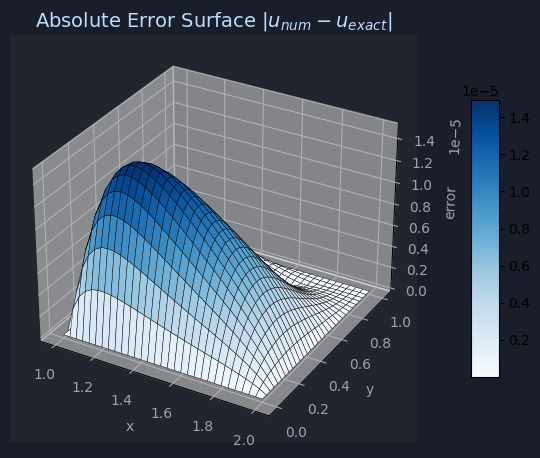

In [256]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)

plt.show()


## Problem 3
### a) Approximate the solutions to the following elliptic partial differential equations:


$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0, \quad 0 < x < 1,\quad 0 < y < 1;
$$

Boundary conditions:

- $u(x, 0) = 0$, $u(x, 1) = x$, $0 \leq x \leq 1$
- $u(0, y) = 0$, $u(1, y) = y$, $0 \leq y \leq 1$

Use $h = k = 0.2$ and compare the results to the actual solution:

$$
u(x, y) = xy
$$


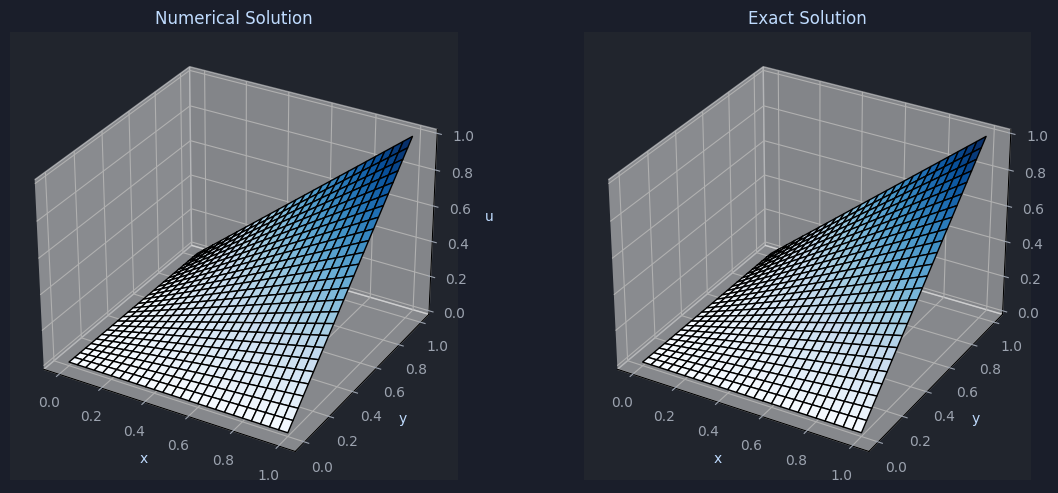

In [257]:
# Define domain and resolution
a, b = 0, 1
c, d = 0, 1
Nx, Ny = 50, 50  # h = k = 0.2 -> (Nx+1)x(Ny+1) = 6 x 6 grid

# RHS of Laplace equation
f_func = lambda x, y: np.zeros_like(x)

# Dirichlet boundary conditions
g_bottom = lambda x: 0 * x       # u(x, 0) = 0
g_top = lambda x: x              # u(x, 1) = x
g_left = lambda y: 0 * y         # u(0, y) = 0
g_right = lambda y: y            # u(1, y) = y

# Exact solution
u_exact = lambda x, y: x * y

# Solve using the PoissonSolver2D class
solver = PoissonSolver2D(a, b, c, d, Nx, Ny, f_func,
                         g_left=g_left, g_right=g_right,
                         g_bottom=g_bottom, g_top=g_top)
u_numeric = solver.solve()
# Evaluate exact solution
X, Y = solver.X, solver.Y
u_true = u_exact(X, Y)
error = np.abs(u_numeric - u_true)

# Plot numerical solution vs exact solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.patch.set_facecolor(colors["slategray"])

# Apply theme to each subplot
for ax in axs:
    ax.set_facecolor(colors["midnight"])
    ax.xaxis.label.set_color(colors["lightblue"])
    ax.yaxis.label.set_color(colors["lightblue"])
    ax.zaxis.label.set_color(colors["lightblue"])
    ax.tick_params(colors=colors["softgray"])
    ax.title.set_color(colors["lightblue"])

# Numerical solution
surf1 = axs[0].plot_surface(X, Y, u_numeric, cmap='Blues', edgecolor='k')
axs[0].set_title("Numerical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("u")

# Exact solution
surf2 = axs[1].plot_surface(X, Y, u_true, cmap='Blues', edgecolor='k')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("u")



plt.tight_layout()
plt.show()



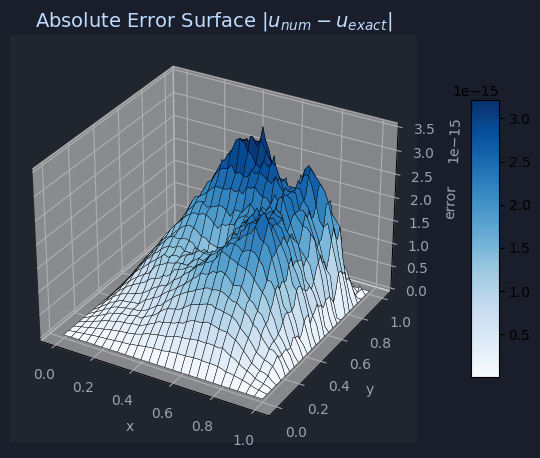

In [258]:
# Compute error surface
error = np.abs(u_numeric - u_true)

# Plot error surface using your custom theme
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor(colors["slategray"])
ax.set_facecolor(colors["midnight"])

# Plot error surface
surf = ax.plot_surface(X, Y, error, cmap='Blues', edgecolor='k', linewidth=0.3)

# Axis labels and title
ax.set_title("Absolute Error Surface $|u_{num} - u_{exact}|$", color=colors["lightblue"], fontsize=14)
ax.set_xlabel("x", color=colors["softgray"])
ax.set_ylabel("y", color=colors["softgray"])
ax.set_zlabel("error", color=colors["softgray"])
ax.tick_params(colors=colors["softgray"])

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)

plt.show()
